In [1]:
from typing import List, Tuple

import isthmuslib
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve

# New(?) indexing approach

This notebook is a minimum viable demonstration of a concise and efficient approach for representing rings, with both size and privacy benefits, that is `O(1)` with ring size. Given a transaction with `N_in` inputs, all ring members positions in all rings can be represented by  a `N_in + 1` length tuple of integers:

`(anchor index, ring marker 1, ring marker 2, ... ring marker N_in)`

The below demonstration `uint32` for both the anchor height `h` and the range of the ring markers `[0, u)`, so the total size of representing all rings is `4 * (N_in + 1)` bytes. We'll use ring size (`r`) of 16 for the demonstration

In [2]:
u: int = 2 ** 32  # uint32
r: int = 16

Let `R` be the ring size

Define some arbitrary ring member selection algorithm (RMSA) that produces a set of R output indices.

The RMSA is like a decoy selection algorithm (DSA). The only difference is that a DSA returns R-1 decoy indices (excluding the real spend) and the RMSA returns R indices (including the real spend).

To show that this indexing approach is not dependent on any particular form of RSA, I'll define it as a kind of absurd amalgamation of functions.

Let `x` be an output index, and let `h` be the height of the chain being specified as an anchor.

In [3]:
def foobar_RMSA(x: int, h: int) -> float:
    b: int = 500_000
    if x < h - b:
        # Define linear relationship to connect at y=10 for x=h-b
        # Slope: (10 - 5) / (h - b - 0) = (5) / (h - b)
        # Intercept: 5 - slope * 0
        slope: float = 5 / (h - b)
        return slope * x + 5
    elif x >= 750_000:
        slope: float = (100 - 10) / b
        intercept: float = 10 - slope * (h - b)
        period: float = b * 0.8
        return (slope * x + intercept) + 20 * np.sin(2 * np.pi * (x - 750_000) / period)
    else:
        slope: float = (100 - 10) / b
        intercept: float = 10 - slope * (h - b)
        return slope * x + intercept


Plot the RMSA for an output set with 1 million indices

In [4]:
anchor_h: int = 1_000_000

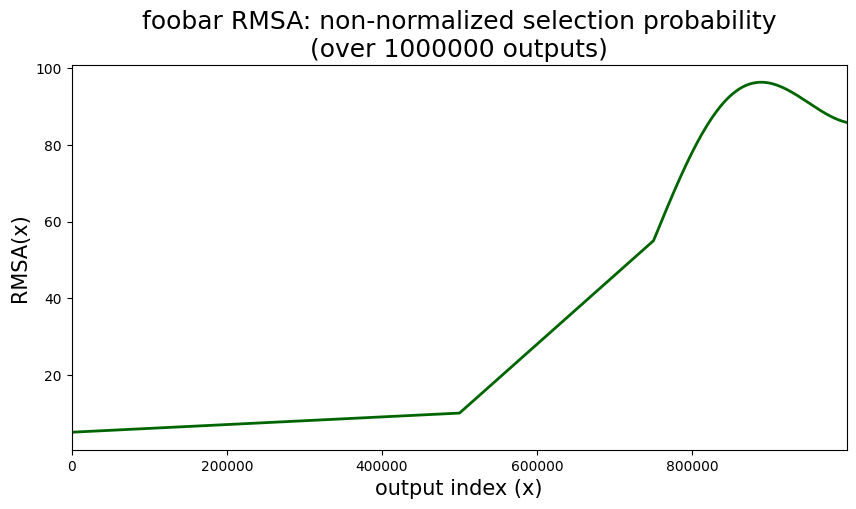

In [5]:
plot_downsample_factor: int = 1000
isthmuslib.plot(
    list(range(1_000_000))[::plot_downsample_factor],
    [foobar_RMSA(x, anchor_h) for x in range(1_000_000)][::plot_downsample_factor],
    multi=False,
    xlabel="output index (x)",
    ylabel="RMSA(x)",
    grid=False,
    figsize=(10, 5),
    title=f'foobar RMSA: non-normalized selection probability\n(over {anchor_h} outputs)',
    show=True,
    downsample=1000,
    linewidth=2,
);

## Building a ring

Let's say we want to construct a ring that contains our true spend, output 777,777

In [6]:
x_true: int = 777_777

## Step 0: Windowing

Break the area under the RMSA curve into `r` even parts

In [7]:
# A wrapper function for the RMSA that takes a single argument. I don't like lambda functions, because they don't pickle.
def rmsa_wrapper(x):
    return foobar_RMSA(x, anchor_h)

In [8]:
def get_windows(r: int, h: int) -> List[Tuple[int, int]]:
    # Estimate the area of each window
    total_area, _ = quad(rmsa_wrapper, 0, h)  # noqa: syntax is OK
    target_area = total_area / r

    # Iterate over windows to determine boundaries
    windows = []
    start_x = 0
    for i in range(r):
        area_func = lambda end_x: quad(lambda x: foobar_RMSA(x, h), start_x, end_x)[0] - target_area
        end_x = start_x + target_area  # Initial guess
        end_x = fsolve(area_func, end_x)[0]  # Use numerical solver to find end_x

        # Match to integer domain and save
        end_x = round(end_x)
        if i < r - 1:
            end_x -= 1
        windows.append((int(start_x), int(end_x)))
        start_x = end_x + 1

    return windows


Visualize the windows

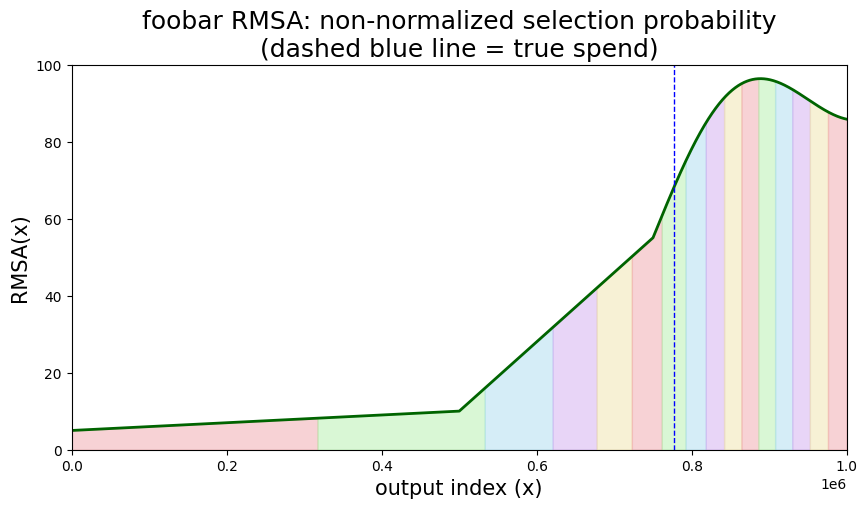

In [9]:
def window_plot_helper(h: int, r: int, get_windows_func, func):
    # Get the RMSA and window values
    x_values: List[float] = list(np.arange(0, h + 1))
    y_values: List[float] = list(np.array([func(x, h) for x in x_values]))
    windows: List[Tuple[float, float]] = get_windows_func(r, h)

    isthmuslib.plot(
        x_values,
        y_values,
        xlabel="output index (x)",
        ylabel="RMSA(x)",
        grid=False,
        figsize=(10, 5),
        title=f'foobar RMSA: non-normalized selection probability\n(dashed blue line = true spend)',
        show=False,
        downsample=1000,
        linewidth=2,
        ylim=(0, 100),
    )

    # Shade the area under the curve based on the window
    colors: List[str] = ["#f0a6ad", "#b4f0ad", "#adddf0", "#d2adf0", "#f0e4ad"]
    for i, (start_x, end_x) in enumerate(windows):
        plt.fill_between(
            x_values[start_x:end_x + 1],
            y_values[start_x:end_x + 1],
            color=colors[i % len(colors)],
            alpha=0.5)
    plt.axvline(x=x_true, color="blue", linestyle="--", linewidth=1)
    plt.show()


windows: List[Tuple[float, float]] = get_windows(r, anchor_h)
window_plot_helper(anchor_h, r, get_windows, foobar_RMSA)